In [1]:
import pandas as pd
import numpy as np
from   sklearn.model_selection import train_test_split
from   sklearn.metrics import accuracy_score
from   sklearn.preprocessing import StandardScaler
from   sklearn import svm
from   sklearn.svm import SVC
from   sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from joblib import load
import os 
from collections import Counter 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_score
from pycaret.clustering import setup, create_model, assign_model, plot_model


In [425]:
dfs = []

base_path = "C:\\classificador-de-padroes-de-mobilidade\\dataset\\raw\\Dataset-FallWatch"
for i in range(1,6):
    folder_name_avd = f"U{i:02d}\\AVD's"
    folder_name_fall = f"U{i:02d}\\Falls"
    
    folder_path_avd = os.path.join(base_path, folder_name_avd)
    folder_path_fall = os.path.join(base_path, folder_name_fall)
    
    for j in range(1, 12):
        file_name_avd = f'U{i:02d} - D{j:02d}.csv'
        file_path_avd = os.path.join(folder_path_avd, file_name_avd)
        
        file_name_fall = f'U{i:02d} - F{j:02d}.csv'
        file_path_fall = os.path.join(folder_path_fall, file_name_fall)
        
        if os.path.exists(file_path_avd):
            dataframe = pd.read_csv(file_path_avd)
            dataframe['idUsuario'] = f'U{i:02d}'
            dataframe['idTipoMovimento'] = f'D{j:02d}'
            dfs.append(dataframe)
            
        if os.path.exists(file_path_fall):
            dataframe = pd.read_csv(file_path_fall)
            dataframe['idUsuario'] = f'U{i:02d}'
            dataframe['idTipoMovimento'] = f'F{j:02d}'
            dfs.append(dataframe)

dataframe = pd.concat(dfs, ignore_index=True)

movimentos_formatados = {"D01":"Caminhando",
"D02":"Correndo",
# "D03":"Subindo e descendo escadas", nao possui no dataset
"D04":"Sentando em uma cadeira, esperar um momento e levantar-se",
"D05":"Sentado por um momento, tentar levantar-se e cair na cadeira",
"D06":"Agachando (dobrando os joelhos), amarrar sapatos e levantar-se",
"D07":"Tropeçar enquanto caminha",
"D08":"Pular suavemente sem cair(tentando alcançar um objeto)",
"D09":"Bater na mesa com a mão",
"D10":"Batendo palmas",
"F01":"Queda para frente ao caminhar causada por escorregão",
"F02":"Queda lateral ao caminhar causada por escorregão",
"F03":"Queda para trás ao caminhar causada por escorregão",
"F04":"Queda para frente ao caminhar causada por tropeço",
"F05":"Queda para trás ao tentar sentar-se",
"F06":"Queda para frente enquanto sentado, causada por desmaio ou adormecimento",
"F07":"Queda para trás enquanto sentado, causada por desmaio ou adormecimento",
"F08":"Queda lateral enquanto sentado, causada por desmaio ou adormecimento",
}

colunas_selecionadas = ['tempo','acelX', 'acelY', 'acelZ' ,'idTipoMovimento']
dataframe = dataframe[colunas_selecionadas]
dataframe['MAGNITUDE_ACEL']   = np.sqrt(dataframe['acelX']**2 + dataframe['acelY']**2 + dataframe['acelZ']**2)
dataframe = dataframe[dataframe['idTipoMovimento'].isin(['D04'])]
# dataframe = dataframe[dataframe['idUsuario'].isin(['U01'])]
dataframe = dataframe[['tempo','acelX', 'acelY', 'acelZ' ,'idTipoMovimento','MAGNITUDE_ACEL']]
dataframe = dataframe.reset_index(drop=True)
primeiro_dataframe = dataframe.iloc[0:501]
segundo_dataframe = dataframe.iloc[501:1002]
# dataframe.shape
intervalos = []
intervalos.append(primeiro_dataframe)
intervalos.append(segundo_dataframe)
dataframe = pd.concat(intervalos, ignore_index=True)
dataframe #selecionando somente U01 e U02 (usuários com gráficos similares)

,tempo,acelX,acelY,acelZ,idTipoMovimento,MAGNITUDE_ACEL
0,0,-1282.0,-1473.0,137.0,D04,1957.555108
1,40,-1267.0,-1509.0,132.0,D04,1974.789609
2,80,-1294.0,-1522.0,125.0,D04,2001.635581
3,120,-1285.0,-1502.0,118.0,D04,1980.190142
4,160,-1305.0,-1491.0,138.0,D04,1986.240167
...,...,...,...,...,...,...
997,19840,-578.0,2048.0,-49.0,D04,2128.565010
998,19880,-589.0,2040.0,-59.0,D04,2124.147358
999,19920,-587.0,2053.0,-48.0,D04,2135.809448
1000,19960,-595.0,2045.0,-58.0,D04,2130.590059


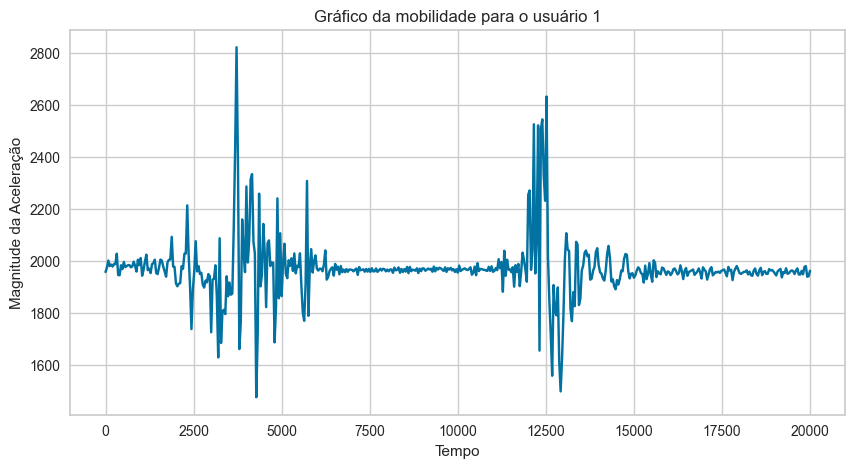

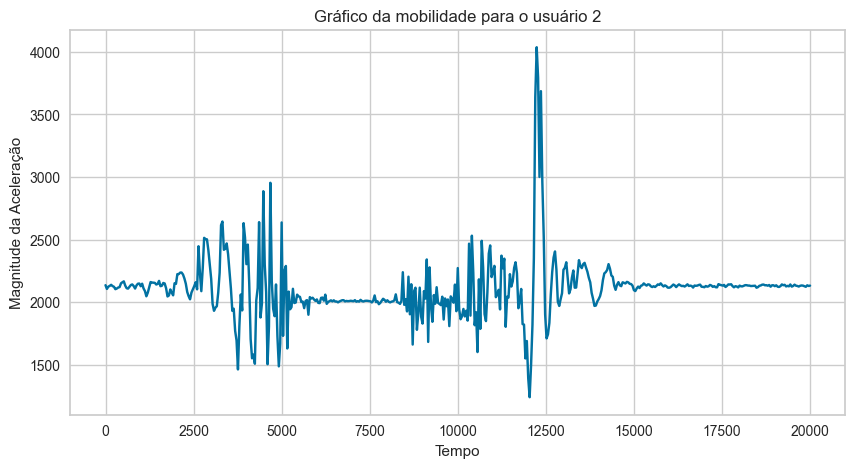

In [426]:
# Considerando que o DataFrame já está filtrado e formatado
num_linhas = 501
num_usuarios = len(dataframe) // num_linhas

for i in range(num_usuarios):
    bloco = dataframe.iloc[i * num_linhas:(i + 1) * num_linhas]
    
    plt.figure(figsize=(10, 5))
    plt.title(f"Gráfico da mobilidade para o usuário {i + 1}")
    plt.plot(bloco['tempo'], bloco['MAGNITUDE_ACEL'])
    plt.xlabel("Tempo")
    plt.ylabel("Magnitude da Aceleração")
    plt.show()


,Description,Value
0,Session id,1193
1,Original data shape,"(1002, 5)"
2,Transformed data shape,"(1002, 5)"
3,Numeric features,5
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2841,278.9861,1.7286,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3806,389.5177,1.1060,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4607,440.1016,1.0107,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5272,477.2150,0.8380,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5268,459.3331,0.8065,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5313,399.4644,0.9229,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6144,717.6203,0.6621,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6302,754.7320,0.7287,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5666,701.4387,0.8771,0,0,0


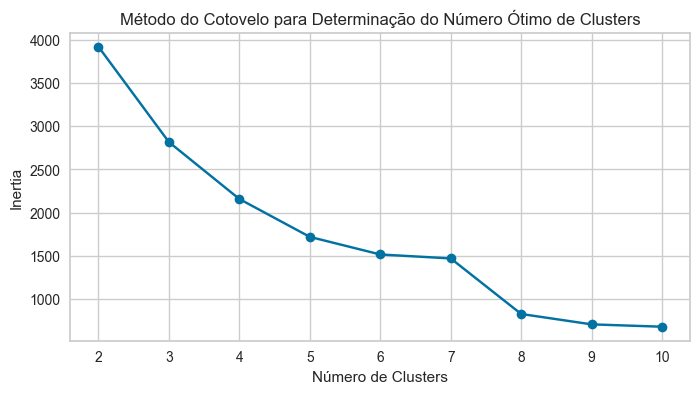

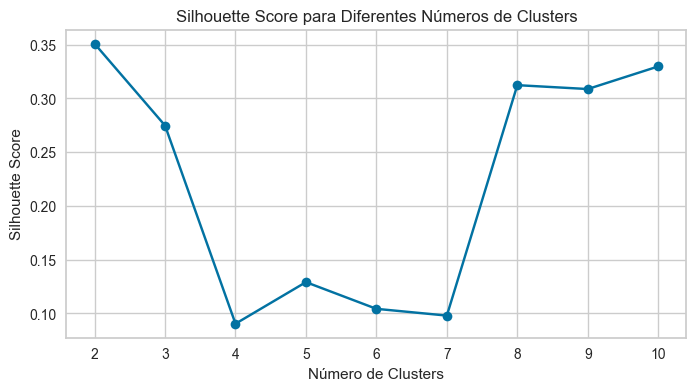

In [428]:
df_segmentos_encoded = pd.get_dummies(dataframe, columns=['idTipoMovimento'], drop_first=True)

# Configurar o ambiente de clusterização no PyCaret
clustering_setup = setup(data=df_segmentos_encoded, normalize=True)

# Testar diferentes números de clusters usando o método do cotovelo
inertia_values = []
silhouette_scores = []
K = range(2,11)  # Testar de 2 a 10 clusters

for k in K:
    # Criar o modelo de K-Means com k clusters
    kmeans = create_model('kmeans', num_clusters=k)
    
    # Atribuir os clusters aos dados
    clustered_data = assign_model(kmeans)
    
    # Calcular e armazenar a Inertia (para o método do cotovelo)
    inertia_values.append(kmeans.inertia_)
    
    # Calcular o Silhouette Score e armazenar
    score = silhouette_score(clustered_data.drop(['Cluster'], axis=1), clustered_data['Cluster'])
    silhouette_scores.append(score)

# Plotar o Método do Cotovelo
plt.figure(figsize=(8, 4))
plt.plot(K, inertia_values, 'bo-', label='Inertia')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.title('Método do Cotovelo para Determinação do Número Ótimo de Clusters')
plt.show()

# Plotar o Silhouette Score
plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, 'bo-', label='Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para Diferentes Números de Clusters')
plt.show()


In [435]:
clustering_setup = setup(data=dataframe, 
                        ignore_features=['tempo','idUsuario','idTipoMovimento'],  
                         normalize=True)  # Normaliza os dados

kmeans = create_model('kmeans', num_clusters=8)

clustered_data = assign_model(kmeans)

print(clustered_data.head())

plot_model(kmeans, plot='cluster')

,Description,Value
0,Session id,5136
1,Original data shape,"(1002, 6)"
2,Transformed data shape,"(1002, 4)"
3,Ignore features,3
4,Numeric features,4
5,Preprocess,True
6,Imputation type,simple
7,Numeric imputation,mean
8,Categorical imputation,mode
9,Normalize,True


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6172,879.5517,0.7394,0,0,0


    acelX   acelY  acelZ  MAGNITUDE_ACEL    Cluster
0 -1282.0 -1473.0  137.0     1957.555054  Cluster 0
1 -1267.0 -1509.0  132.0     1974.789551  Cluster 0
2 -1294.0 -1522.0  125.0     2001.635620  Cluster 0
3 -1285.0 -1502.0  118.0     1980.190186  Cluster 0
4 -1305.0 -1491.0  138.0     1986.240112  Cluster 0


In [436]:
temp = clustered_data['Cluster']
dataframe_clusterizado = dataframe
dataframe_clusterizado['Cluster'] = temp        

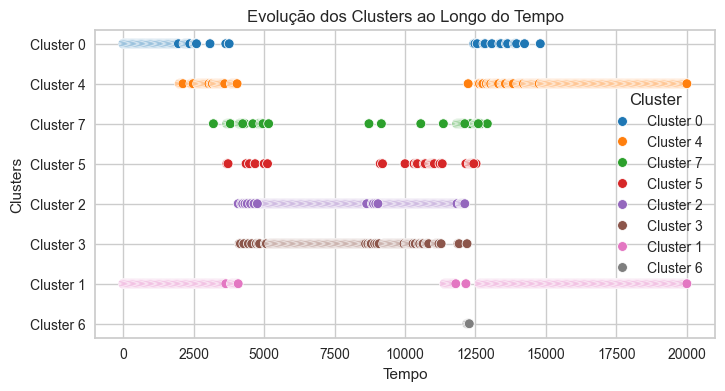

In [437]:
plt.figure(figsize=(8, 4))

# Se os clusters forem categóricos (nominais)
sns.scatterplot(data=dataframe_clusterizado, x='tempo', y='Cluster', hue='Cluster', palette='tab10', s=50)

# Configurar título e rótulos dos eixos
plt.title('Evolução dos Clusters ao Longo do Tempo')
plt.xlabel('Tempo')
plt.ylabel('Clusters')

plt.grid(True)
plt.show()

In [438]:
dataframe_clusterizado['Cluster Processado'] = dataframe_clusterizado['Cluster'].apply(
    lambda x: 1 if x in {'Cluster 1','Cluster 4'} else 0
)
dataframe_clusterizado

,tempo,acelX,acelY,acelZ,idTipoMovimento,MAGNITUDE_ACEL,Cluster,Cluster Processado
0,0,-1282.0,-1473.0,137.0,D04,1957.555108,Cluster 0,0
1,40,-1267.0,-1509.0,132.0,D04,1974.789609,Cluster 0,0
2,80,-1294.0,-1522.0,125.0,D04,2001.635581,Cluster 0,0
3,120,-1285.0,-1502.0,118.0,D04,1980.190142,Cluster 0,0
4,160,-1305.0,-1491.0,138.0,D04,1986.240167,Cluster 0,0
...,...,...,...,...,...,...,...,...
997,19840,-578.0,2048.0,-49.0,D04,2128.565010,Cluster 1,1
998,19880,-589.0,2040.0,-59.0,D04,2124.147358,Cluster 1,1
999,19920,-587.0,2053.0,-48.0,D04,2135.809448,Cluster 1,1
1000,19960,-595.0,2045.0,-58.0,D04,2130.590059,Cluster 1,1


In [439]:
# Parâmetros
intervalo_amostras = 10  # número de amostras por segmento (400ms)

# Inicializar listas para armazenar os resultados
medias_mag = []
maximas_mag = []
minimas_mag = []
dados_segmentos = []

# Analisar segmentos com janela deslizante
for i in range(len(dataframe) - intervalo_amostras + 1):
    segmento = dataframe.iloc[i:i + intervalo_amostras]

    media_x = segmento['acelX'].mean()
    media_y = segmento['acelY'].mean()
    media_z = segmento['acelZ'].mean()
    media_mag = segmento['MAGNITUDE_ACEL'].mean()
    
    max_x = segmento['acelX'].max()
    max_y = segmento['acelY'].max()
    max_z = segmento['acelZ'].max()
    max_mag = segmento['MAGNITUDE_ACEL'].max()
    
    min_x = segmento['acelX'].min()
    min_y = segmento['acelY'].min()
    min_z = segmento['acelZ'].min()
    min_mag = segmento['MAGNITUDE_ACEL'].min()
    
    # Pegando o idTipoMovimento e o Cluster Processado para o segmento
    id_tipo_movimento = segmento['idTipoMovimento'].iloc[0]
    cluster_processado = segmento['Cluster Processado'].iloc[0]

    # Adicionando as métricas à lista
    medias_mag.append(media_mag)
    maximas_mag.append(max_mag)
    minimas_mag.append(min_mag)

    # Adicionando os dados do segmento à lista de dados
    dados_segmentos.append({
        'seg': i + 1,
        'idTipoMovimento': id_tipo_movimento,
        'Cluster Processado': cluster_processado,
        'med_x': media_x,
        'med_y': media_y,
        'med_z': media_z,
        'med_mag': media_mag,
        'max_x': max_x,
        'max_y': max_y,
        'max_z': max_z,
        'max_mag': max_mag,
        'min_x': min_x,
        'min_y': min_y,
        'min_z': min_z,
        'min_mag': min_mag
    })

# Criar um DataFrame com os dados dos segmentos
df_segmentos = pd.DataFrame(dados_segmentos)

# Calcular diferenças entre segmentos consecutivos para a magnitude_acel
media_difs_mag = np.diff(medias_mag)
maxima_difs_mag = np.diff(maximas_mag)
minima_difs_mag = np.diff(minimas_mag)

# Calcular desvios padrão das diferenças
media_dif_std = np.std(media_difs_mag)
maxima_dif_std = np.std(maxima_difs_mag)
minima_dif_std = np.std(minima_difs_mag)

# Adicionar as diferenças ao DataFrame de segmentos
df_segmentos['media_dif'] = [None] + list(media_difs_mag)
df_segmentos['maxima_dif'] = [None] + list(maxima_difs_mag)
df_segmentos['minima_dif'] = [None] + list(minima_difs_mag)

# Exibir o DataFrame resultante
df_segmentos = df_segmentos.drop(columns=['seg','idTipoMovimento'])
df_segmentos


,Cluster Processado,med_x,med_y,med_z,med_mag,max_x,max_y,max_z,max_mag,min_x,min_y,min_z,min_mag,media_dif,maxima_dif,minima_dif
0,0,-1279.8,-1508.1,138.1,1982.903944,-1230.0,-1473.0,173.0,2027.999260,-1305.0,-1556.0,118.0,1945.978674,NaN,NaN,NaN
1,0,-1276.0,-1509.6,139.2,1981.662803,-1230.0,-1488.0,173.0,2027.999260,-1305.0,-1556.0,118.0,1945.143696,-1.241141,0.000000,-0.834978
2,0,-1274.8,-1511.8,138.2,1982.523701,-1230.0,-1488.0,173.0,2027.999260,-1305.0,-1556.0,118.0,1945.143696,0.860899,0.000000,0.000000
3,0,-1272.7,-1508.9,141.6,1979.206759,-1230.0,-1488.0,173.0,2027.999260,-1305.0,-1556.0,118.0,1945.143696,-3.316943,0.000000,0.000000
4,0,-1275.4,-1508.3,145.9,1980.819430,-1230.0,-1488.0,173.0,2027.999260,-1312.0,-1556.0,122.0,1945.143696,1.612672,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,1,-584.6,2049.0,-57.7,2131.564568,-574.0,2055.0,-49.0,2141.109525,-598.0,2042.0,-62.0,2125.633317,-1.402688,-1.482363,0.000000
989,1,-584.7,2048.8,-58.3,2131.415972,-574.0,2055.0,-49.0,2141.109525,-598.0,2040.0,-62.0,2124.147358,-0.148596,0.000000,-1.485959
990,1,-584.2,2049.5,-57.1,2131.919936,-574.0,2055.0,-48.0,2141.109525,-598.0,2040.0,-62.0,2124.147358,0.503963,0.000000,0.000000
991,1,-583.9,2048.5,-56.8,2130.867989,-574.0,2055.0,-48.0,2135.809448,-595.0,2040.0,-62.0,2124.147358,-1.051947,-5.300077,0.000000


In [440]:
df_segmentos_restaurado = df_segmentos.copy()  

df_segmentos = df_segmentos_restaurado.dropna()

X = df_segmentos.drop(columns=['Cluster Processado'])
y = df_segmentos['Cluster Processado']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC(kernel='linear')  
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

with open('svm_model.joblib', 'wb') as file:
    dump(model, file)


[[ 84   4]
 [  5 106]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95        88
           1       0.96      0.95      0.96       111

    accuracy                           0.95       199
   macro avg       0.95      0.95      0.95       199
weighted avg       0.95      0.95      0.95       199

